In [1]:
import pandas as pd

In [2]:
no_missing_merged_loc = pd.read_csv('clean_for_training.csv')

In [7]:
no_missing_merged_loc.drop(columns='Unnamed: 0', inplace=True)

In [26]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import pickle

# Define features (X) and target (y)
X = no_missing_merged_loc.drop(columns=['amount'])  # Replace 'amount' with your target column if different
y = no_missing_merged_loc['amount']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data for meta-learner (optional)
X_train_base, X_val_meta, y_train_base, y_val_meta = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Initialize QuantileTransformers
qt_amount = QuantileTransformer(output_distribution='normal', random_state=42)
qt_size = QuantileTransformer(output_distribution='normal', random_state=42)

# Fit transformers on training data
# Fit qt_size on transaction and property sizes
qt_size.fit(X_train[['transaction_size_sqm', 'property_size_sqm']])

# Fit qt_amount on the entire `y_train` dataset
qt_amount.fit(y_train.values.reshape(-1, 1))

# Transform sizes in the training, validation, and test sets
X_train_base[['transaction_size_sqm', 'property_size_sqm']] = qt_size.transform(
    X_train_base[['transaction_size_sqm', 'property_size_sqm']]
)
X_val_meta[['transaction_size_sqm', 'property_size_sqm']] = qt_size.transform(
    X_val_meta[['transaction_size_sqm', 'property_size_sqm']]
)
X_test[['transaction_size_sqm', 'property_size_sqm']] = qt_size.transform(
    X_test[['transaction_size_sqm', 'property_size_sqm']]
)

# Transform target variable in the training, validation, and test sets
y_train_base = qt_amount.transform(y_train_base.values.reshape(-1, 1)).flatten()
y_val_meta = qt_amount.transform(y_val_meta.values.reshape(-1, 1)).flatten()
y_test = qt_amount.transform(y_test.values.reshape(-1, 1)).flatten()

# Save the transformers for later use
with open("qt_amount.pkl", "wb") as f:
    pickle.dump(qt_amount, f)
with open("qt_size.pkl", "wb") as f:
    pickle.dump(qt_size, f)

# Print dataset sizes
print(f"Training set (Base models): {X_train_base.shape}")
print(f"Validation set (Meta-learner): {X_val_meta.shape}")
print(f"Test set: {X_test.shape}")




Training set (Base models): (97683, 51)
Validation set (Meta-learner): (32561, 51)
Test set: (32562, 51)


In [28]:
y_train_base.mean()

-0.003921848786844588

Transformed y_train_base (mean, std): -0.003921848786844588 1.0034234296799391
Transformed transaction_size_sqm (mean, std): 0.007203983450588102 0.9941383070619169
Transformed property_size_sqm (mean, std): 0.008337192434127833 0.9942399468406207


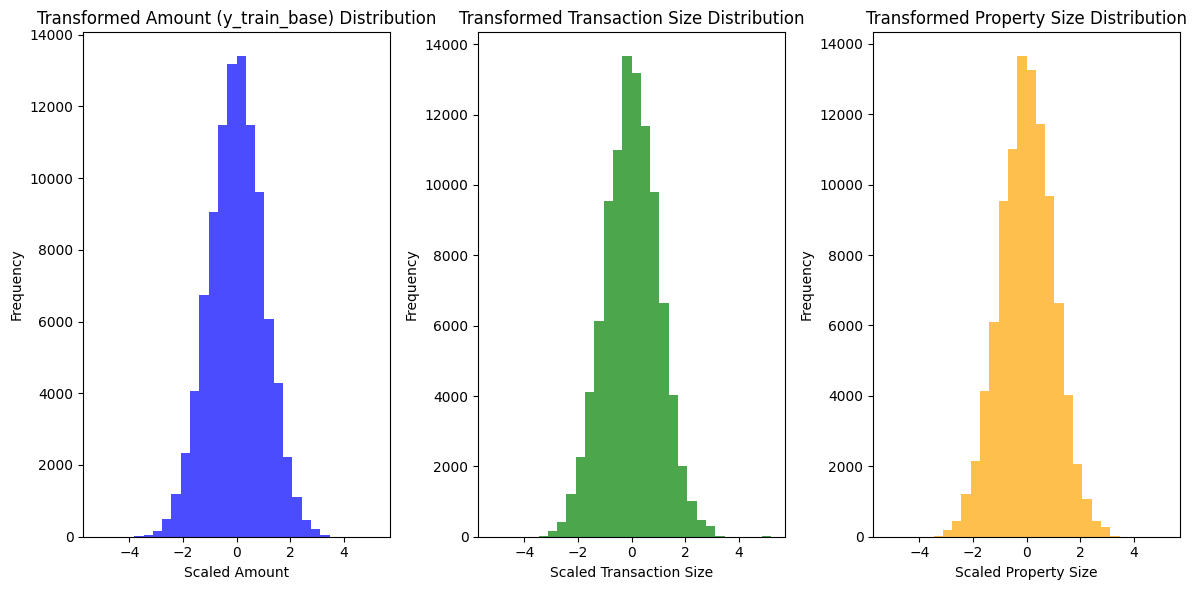

In [29]:
import numpy as np

# Check the transformed training data
print("Transformed y_train_base (mean, std):", np.mean(y_train_base), np.std(y_train_base))
print("Transformed transaction_size_sqm (mean, std):",
      np.mean(X_train_base['transaction_size_sqm']), np.std(X_train_base['transaction_size_sqm']))
print("Transformed property_size_sqm (mean, std):",
      np.mean(X_train_base['property_size_sqm']), np.std(X_train_base['property_size_sqm']))

# Verify that the transformed data is approximately normal
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(y_train_base, bins=30, color='blue', alpha=0.7)
plt.title("Transformed Amount (y_train_base) Distribution")
plt.xlabel("Scaled Amount")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(X_train_base['transaction_size_sqm'], bins=30, color='green', alpha=0.7)
plt.title("Transformed Transaction Size Distribution")
plt.xlabel("Scaled Transaction Size")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(X_train_base['property_size_sqm'], bins=30, color='orange', alpha=0.7)
plt.title("Transformed Property Size Distribution")
plt.xlabel("Scaled Property Size")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np

# Define XGBoost optimization
def optimize_xgboost(trial, X_train, y_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
    }
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    return model.score(X_train, y_train)

# Define Random Forest optimization
def optimize_random_forest(trial, X_train, y_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
    }
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    return model.score(X_train, y_train)

# Define SVR optimization
def optimize_svr(trial, X_train, y_train):
    params = {
        "C": trial.suggest_loguniform("C", 0.1, 100),
        "epsilon": trial.suggest_loguniform("epsilon", 0.01, 1),
        "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "poly"]),
    }
    model = SVR(**params)
    model.fit(X_train, y_train)
    return model.score(X_train, y_train)

# Define optimization function
def optimize_model(optimize_func, X_train, y_train, n_trials=20):
    def objective(trial):
        return optimize_func(trial, X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

# Example usage with your dataset
# Assuming X_train_base and y_train_base are defined
# Optimize XGBoost
best_params_xgb = optimize_model(optimize_xgboost, X_train_base, y_train_base)
print("Best parameters for XGBoost:", best_params_xgb)

# Optimize Random Forest
best_params_rf = optimize_model(optimize_random_forest, X_train_base, y_train_base)
print("Best parameters for Random Forest:", best_params_rf)

# Optimize SVR
best_params_svr = optimize_model(optimize_svr, X_train_base, y_train_base)
print("Best parameters for SVR:", best_params_svr)



[I 2024-11-24 23:16:51,838] A new study created in memory with name: no-name-c185a0f9-2c29-4a2b-8b46-85712cbb9e7d
/tmp/ipykernel_3883/2769754504.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
/tmp/ipykernel_3883/2769754504.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
[I 2024-11-24 23:16:53,290] Trial 0 finished with value: 0.8949473065946467 and parameters: {'n_estimators': 287, 'max_depth': 4, 'learning_rate': 0.09231314897420198, 'subsample': 0.7708888685151052}. Best is trial 0 with value: 0.8949473065946467.
/tmp/ipykernel_3883/2769754504.py:

Best parameters for XGBoost: {'n_estimators': 361, 'max_depth': 10, 'learning_rate': 0.24829236737227453, 'subsample': 0.875390416499723}


[I 2024-11-24 23:20:04,913] Trial 0 finished with value: 0.6207472637634928 and parameters: {'n_estimators': 319, 'max_depth': 3, 'min_samples_split': 4}. Best is trial 0 with value: 0.6207472637634928.
[I 2024-11-24 23:21:27,646] Trial 1 finished with value: 0.8819598151346302 and parameters: {'n_estimators': 138, 'max_depth': 9, 'min_samples_split': 3}. Best is trial 1 with value: 0.8819598151346302.
[I 2024-11-24 23:27:06,311] Trial 2 finished with value: 0.9108620148408898 and parameters: {'n_estimators': 498, 'max_depth': 11, 'min_samples_split': 18}. Best is trial 2 with value: 0.9108620148408898.
[I 2024-11-24 23:28:55,448] Trial 3 finished with value: 0.9637477375020596 and parameters: {'n_estimators': 111, 'max_depth': 20, 'min_samples_split': 11}. Best is trial 3 with value: 0.9637477375020596.
[I 2024-11-24 23:31:26,307] Trial 4 finished with value: 0.9349791211334565 and parameters: {'n_estimators': 195, 'max_depth': 13, 'min_samples_split': 8}. Best is trial 3 with value: 

Best parameters for Random Forest: {'n_estimators': 111, 'max_depth': 20, 'min_samples_split': 11}


[I 2024-11-25 00:20:24,855] Trial 0 finished with value: 0.2841205802303344 and parameters: {'C': 5.345724752117849, 'epsilon': 0.4658506335934677, 'kernel': 'rbf'}. Best is trial 0 with value: 0.2841205802303344.
/tmp/ipykernel_3883/2769754504.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 0.1, 100),
/tmp/ipykernel_3883/2769754504.py:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "epsilon": trial.suggest_loguniform("epsilon", 0.01, 1),
[I 2024-11-25 00:40:25,866] Trial 1 finished with value: 0.0964864670873824 and parameters: {'C': 0.29009995811636596, 'epsilon': 0.023811950015925155, 'kernel': 'poly'}. Best is trial 0 with v